# BEAST Workflow Example

This tutorial provides an example for how to use the Bayesian Extinction and Stellar Tool (BEAST). The tutorial was generated from a Jupyter notebook, which can be downloaded [here](https://github.com/BEAST-Fitting/beast/tree/master/docs/tutorial.ipynb). 

Before starting, please make sure you have at least BEAST v2.0 installed. 

In [8]:
import h5py

import numpy as np
from astropy import wcs
from astropy.io import fits
from astropy.table import Table

import glob
import os
import types
import argparse
import importlib
from IPython.display import Image


import matplotlib.pyplot as plt
%matplotlib inline

from beast.plotting import (plot_mag_hist, 
                            plot_ast_histogram, 
                            plot_noisemodel)

from beast.tools.run import (
    create_physicsmodel,
    make_ast_inputs,
    create_obsmodel,
    run_fitting,
    merge_files,
    create_filenames,
)

from beast.physicsmodel.grid import SEDGrid
from beast.fitting import trim_grid
import beast.observationmodel.noisemodel.generic_noisemodel as noisemodel
from beast.observationmodel.observations import Observations
    
from beast.tools import (
     beast_settings,
     create_background_density_map,
     split_ast_input_file,
     split_catalog_using_map,
     cut_catalogs,
     setup_batch_beast_trim,
)

For this example, we will be walking through a standard BEAST workflow example using photometry from the [Panchromatic Hubble Andromeda Treasury (PHAT)](https://archive.stsci.edu/hlsp/phat) survey. 

If you are running this example notebook locally, the example data can be fetched [here](https://www.dropbox.com/sh/91aefrp9gzdc9z0/AAC9Gc4KIRIB520g6a0uLLama?dl=0)

Download the files manually from the link above and place them in a folder called `/data` within the same folder as this notebook.

## Step 1a. Make magnitude histograms

The first thing we need to do is understand the range of stellar magnitudes we are working with in this data set.

To do this we can make histograms of all the magnitudes of all the stars in all the different filters from the photometric catalog. This is done so that we know where the peaks of the histograms are in each filter. These peaks will then be used later when we make source density maps.

Essentially what happens is that, for the density maps, we only count objects within a certain range, currently set to mag_cut = 15 - (peak_for_filter-0.5). So if the peak was 17.5, then the objects that would be counted would have to be in the range between 15 and 18.

The reason we only count brighter sources is because dimmer sources tend to not be properly observed, especially as the magnitudes near the telescope limit. There will always be far more dim sources than bright sources, but if we know how many bright sources there are, then we can extrapolate as to how many dim sources there should be, and probably get a better understand from that than if we were to try and actually count all the dim sources we detect.

**Variable Information**

- field_name : the string name of the main photometric catalog we are working with. This variable will be used to rename a lot of different files in the future which is why we have it as a separate variable.
- gst_file : stands for good-stars, this is the full name for the original photometric catalog we are working with.

In [2]:
field_name = "M31-B09-EAST_chunk"
gst_file = "./data/%s.st.fits" %field_name

We can see what type of data this fits file holds by making a table. There should be around 50,000 sources in this calalog, which is quite small compared to the original file.

Note: st stands for stars. We also sometimes name things gst for good stars to signify when cuts have been made.

In [3]:
hdul = fits.open(gst_file)
Table(hdul[1].data)

F814W_ST,F814W_GST,F475W_ST,F475W_GST,F275W_ST,F275W_GST,F160W_ST,F160W_GST,F336W_ST,F336W_GST,F110W_ST,F110W_GST,X,Y,RA,DEC,CHI_GL,SNR_GL,SHARP_GL,ROUND_GL,CROWD_GL,F475W_COUNT,F475W_SKY,F475W_RATE,F475W_RATERR,F475W_VEGA,F475W_TRANS,F475W_ERR,F475W_CHI,F475W_SNR,F475W_SHARP,F475W_ROUND,F475W_CROWD,F814W_COUNT,F814W_SKY,F814W_RATE,F814W_RATERR,F814W_VEGA,F814W_TRANS,F814W_ERR,F814W_CHI,F814W_SNR,F814W_SHARP,F814W_ROUND,F814W_CROWD,F275W_COUNT,F275W_SKY,F275W_RATE,F275W_RATERR,F275W_VEGA,F275W_TRANS,F275W_ERR,F275W_CHI,F275W_SNR,F275W_SHARP,F275W_ROUND,F275W_CROWD,F336W_COUNT,F336W_SKY,F336W_RATE,F336W_RATERR,F336W_VEGA,F336W_TRANS,F336W_ERR,F336W_CHI,F336W_SNR,F336W_SHARP,F336W_ROUND,F336W_CROWD,F110W_COUNT,F110W_SKY,F110W_RATE,F110W_RATERR,F110W_VEGA,F110W_TRANS,F110W_ERR,F110W_CHI,F110W_SNR,F110W_SHARP,F110W_ROUND,F110W_CROWD,F160W_COUNT,F160W_SKY,F160W_RATE,F160W_RATERR,F160W_VEGA,F160W_TRANS,F160W_ERR,F160W_CHI,F160W_SNR,F160W_SHARP,F160W_ROUND,F160W_CROWD,EXT,CHIP,MAJAX_GL,OBJTYPE_GL,F475W_FLAG,F814W_FLAG,F275W_FLAG,F336W_FLAG,F110W_FLAG,F160W_FLAG
bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
True,True,True,True,True,True,True,True,True,True,True,True,869.8900000046692,44.40999999483233,11.131832570656686,41.603419438518735,4.03,2917.0,-0.03,0.02,0.251,233000000.0,87358.19,9.039999999999999e-08,1.3800000000000002e-09,17.61,17.721,0.017,2.48,65.4,0.005,0.038,0.175,198000000.0,102360.6,1.59e-07,1.27e-09,16.996,16.986,0.009000000000000001,1.77,124.8,0.01,0.049,0.22699999999999998,5970000.0,2256.98,1.25e-07,1.16e-09,17.255,nan,0.01,2.92,107.7,-0.038,0.018000000000000002,0.086,23800000.0,7534.45,1.69e-07,6.92e-10,16.932000000000002,nan,0.004,2.63,243.9,-0.031,0.059000000000000004,0.084,79700000.0,88039.23,1.6e-07,2.58e-10,16.992,nan,0.002,2.23,619.1,-0.004,0.1,0.35,56000000.0,93657.59,1.8e-07,2.53e-10,16.864,nan,0.002,1.51,708.8,-0.018000000000000002,0.027000000000000003,0.396,0,1,165,1,2,2,0,0,0,0
True,True,True,True,True,True,True,True,True,True,True,True,868.3900000040028,42.189999993549804,11.13180414033402,41.60338891056161,4.13,2566.5,-0.05,0.028999999999999998,0.27699999999999997,125000000.0,46004.84,4.85e-08,2.51e-10,18.285999999999998,18.412,0.006,3.02,193.3,-0.053,-0.006,0.231,118000000.0,77080.48,9.23e-08,1.24e-09,17.587,17.577,0.015,5.87,74.3,-0.096,0.044000000000000004,0.324,4360000.0,2332.74,9.15e-08,7.099999999999999e-10,17.597,nan,0.008,2.08,128.8,-0.057,0.008,0.092,16500000.0,8339.99,1.1699999999999999e-07,9.25e-10,17.329,nan,0.009000000000000001,3.74,126.5,-0.085,-0.006999999999999999,0.106,49500000.0,82165.18,9.92e-08,2.82e-10,17.508,nan,0.003,2.79,352.5,0.013000000000000001,-0.079,0.516,35100000.0,87515.55,1.13e-07,3.31e-10,17.371,nan,0.003,2.18,340.0,-0.026000000000000002,-0.004,0.635,0,1,75,1,2,2,0,2,0,0
True,True,False,False,False,False,True,True,False,False,True,True,297.1500000049341,22.169999994536283,11.135275566985227,41.595888643103535,1.17,1663.1,-0.08800000000000001,0.061,0.008,29910.7,10270.95,1.1499999999999999e-11,1.34e-12,27.348000000000003,27.805999999999997,0.126,1.34,8.6,-0.634,0.177,0.025,4160000.0,21190.25,3.17e-09,1.0000000000000001e-11,21.248,21.423000000000002,0.003,0.9,316.3,-0.063,0.049,0.001,-1.7,44.5,-6.900000000000001e-14,1.49e-11,nan,nan,9.999,0.87,-0.0,1.058,2.951,0.0

As we can see, there's a lot of columns and even more rows. For plotting the magnitude histograms, we're going to be interested in any column that contains the name VEGA. These are the columns with the magnitudes for each filter.

We could also use the X and Y columns to plot where are the sources are located, or the RA and DEC to map their actual position in the sky.

In larger projects we might have multiple fields to analyze during each run, so there would be multiple field_names. Since this is just a small example, we just have one field so our index will always be equal to 0.

In [4]:
# the list of fields (we only have 1 for this example.)
field_names = [field_name]

Now we can create some histogram plots to visualize the magnitude distribution of our sources.



In [14]:
# this 'if' statement just checks if there's already a histogram file
image_file = './data/'+field_names[0]+'.st_maghist.pdf'
if not os.path.isfile(image_file):
    peak_mags = plot_mag_hist.plot_mag_hist(gst_file, stars_per_bin=70, max_bins=75)

You can check out the results for the histograms in the file ending with _maghist.pdf. They should look something like this.

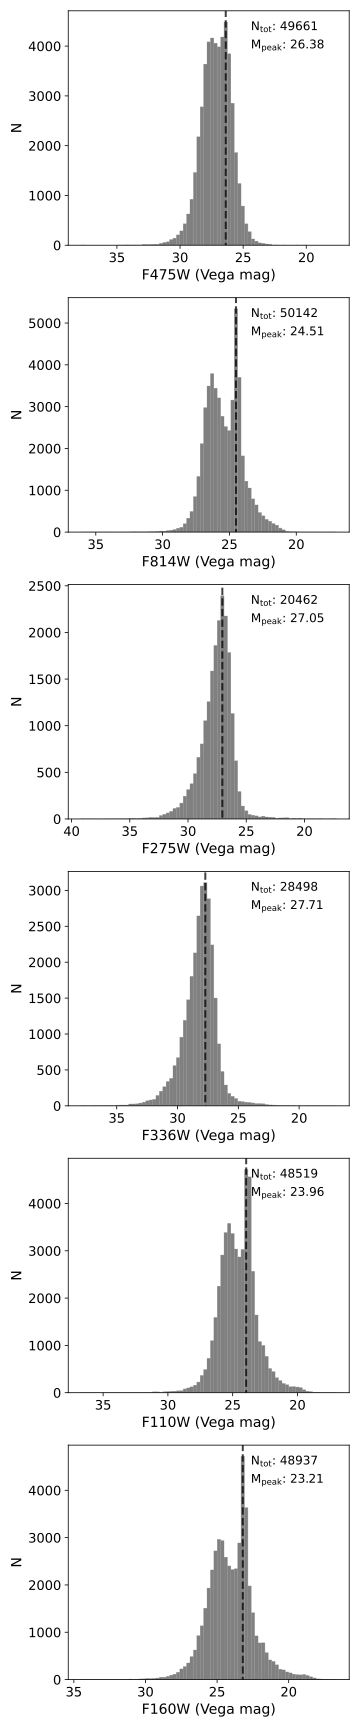

From this plot, we can see that the sources in our field was observed in six different filters, and that the majority of sources are roughly between 20-30 mag in brightness depending on the filter.



## Step 1b. Make source density maps

Next we'll be creating source density maps. These are maps of our data field colored such that they show how many stars/sources there are in each degree field. The standard size is 5 arcsec squared. 

Since we are working with a smaller subset of data, we run the risk of not having enough stars in each source density bin later on when we calculate the noisemodel. To avoid this, we have set our pixel size for this example to 15 arsec, which gives us fewer source density bins but more stars in each source density bin. The size can easily be changed by modifying the `pixsize` variable below.

In [17]:
# Pick the filter with the dimmest peak from the histogram
ref_filter =["F475W"]

# choose a filter to use for removing artifacts
# (remove catalog sources with filter_FLAG > 99)
flag_filter = ["F475W"]

In [19]:
sourceden_args

namespace(subcommand='sourceden',
          catfile='./data/M31-B09-EAST_chunk.st.fits',
          pixsize=15,
          npix=None,
          mag_name='F475W_VEGA',
          mag_cut=[17, 25.878066666666665],
          flag_name='F475W_FLAG')

In [45]:
?create_background_density_map

In [21]:
# check to see if the sourde density file already exists
if not os.path.isfile(gst_file.replace(".fits", "_source_den_image.fits")):
    # if not, run all this other code
    
    # - pixel size of 15 arcsec
    # - use ref_filter[b] between vega mags of 15 and peak_mags[ref_filter[b]]-0.5
        # since we're only working with one field, our index b is set to 0
    sourceden_args = types.SimpleNamespace(
        subcommand="sourceden",
        catfile=gst_file,
        pixsize=15,
        npix=None,
        mag_name=ref_filter[0]+ "_VEGA",
        mag_cut=[17, peak_mags[ref_filter[0]] - 0.5],
        flag_name=flag_filter[0]+'_FLAG',
        diffSpike=None,
        erode_boundary=None
    )
    
    create_background_density_map.main_make_map(sourceden_args)

# of x & y pixels =  4 4
working on converting ra, dec to pix x,y


In [22]:
# new file name with the source density column
gst_file_sd = gst_file.replace(".fits", "_with_sourceden.fits")

This function should create 3 files:

M31-B09-EAST_subset.st_source_den_image.fits : a file for viewing the source density information in ds9 or with matplotlib

M31-B09-EAST_subset.st_sourceden_map.hd5 : the same file as source_den_image but now with even more data (the split_catalog_using_map function will end up using this file later on)

M31-B09-EAST_subset.st_with_sourceden.fits : the same as the original photometric file (gst_file) but now with an additional column for what density bin the source is located in

### View the fits images of the source density maps
Now that we have the source density maps outputted, we can plot the image and see that the density looks like.

In [42]:
stats = Table.read(gst_file)

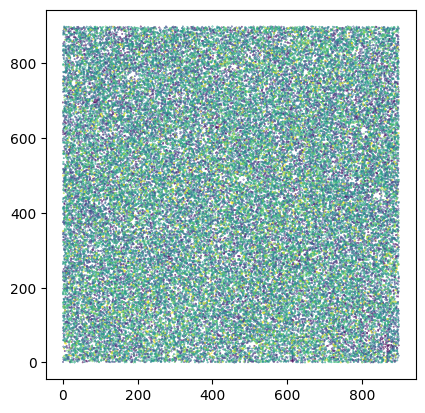

In [43]:
fig, ax = plt.subplots(1,1)

ax.scatter(stats["X"], stats["Y"], s=0.1, c=stats["F475W_VEGA"], vmin=25, vmax=30)
ax.set_aspect("equal")


Filename: ./data/M31-B09-EAST_chunk.st_source_den_image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      20   (4, 4)   float64   


Text(0.5, 1.0, 'Density of Sources per 15 arcsec^2')

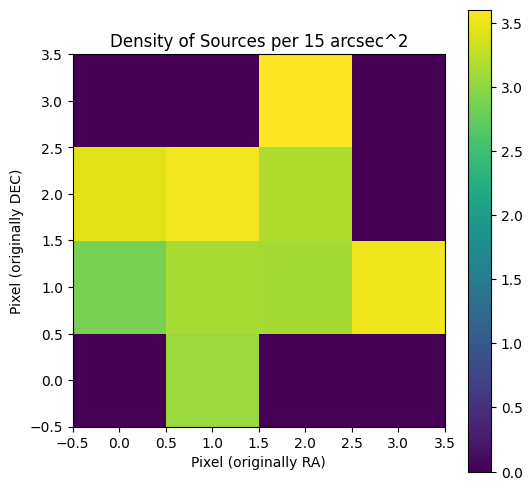

In [37]:
# open the fits file
hdu_list = fits.open("./data/%s.st_source_den_image.fits"%field_name)
hdu_list.info()

# extract the image data
image_data = hdu_list[0].data

# close the fits file
hdu_list.close()

# plot the extracted image data
fig = plt.figure(0, [6,6])
im = plt.imshow(image_data, origin="lower")
plt.colorbar(im)
plt.xlabel("Pixel (originally RA)")
plt.ylabel("Pixel (originally DEC)")
plt.title("Density of Sources per 15 arcsec^2")